# Mask R-CNN - Inspect Ballon Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [44]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.balloon import balloon

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
BALLON_WEIGHTS_PATH = "mask_rcnn_balloon_0165.h5" #"/path/to/mask_rcnn_balloon.h5"  # TODO: update this path

## Configurations

In [74]:
config = balloon.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "datasets/cocoOLD")

In [75]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  400
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Notebook Preferences

In [76]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [77]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [78]:
# Load validation dataset
dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 145
Classes: ['BG', 'broken part', 'crack', 'dent', 'lamp broken', 'missing part', 'scratch']


## Load Model

In [79]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [80]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  D:\Mask_RCNN\logs\balloon20250507T1942\mask_rcnn_balloon_0200.h5
Re-starting from epoch 200


## Run Detection

image ID: balloon.004472_jpg.rf.269db02b507f4b49da260b9b634261e2.jpg (9) D:\Mask_RCNN\datasets/cocoOLD\val\004472_jpg.rf.269db02b507f4b49da260b9b634261e2.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
gt_class_id              shape: (9,)                  min:    1.00000  max:    6.00000  int32
gt_bbox                  shape: (9, 4)                min:  180.00000  max:  446.00000  int32
gt_mask                  shape: (512, 512, 9)         min:    0.00000  max:    1.00000  uint8


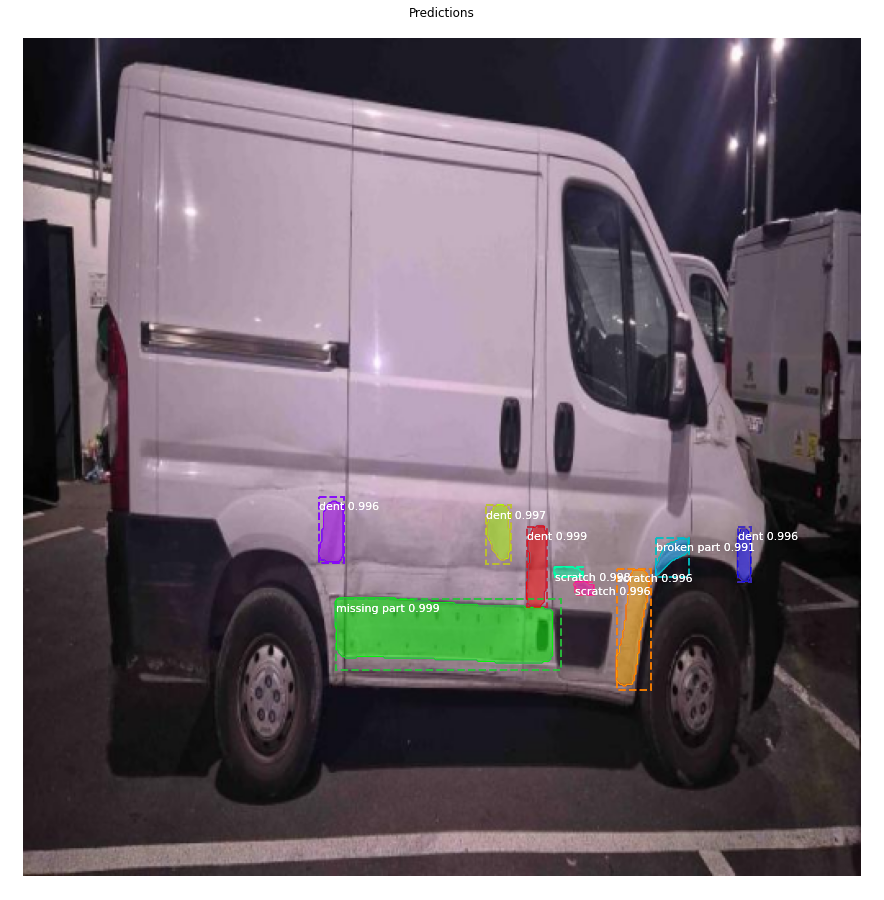

In [81]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

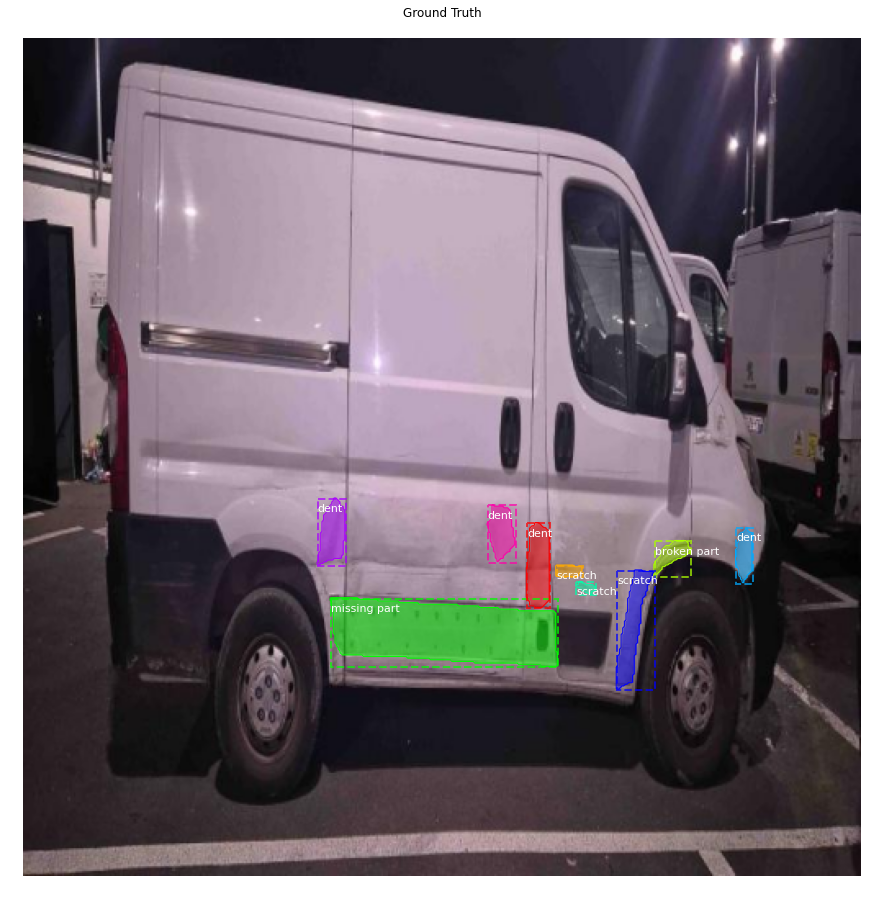

In [82]:
# Display image with ground truth annotations
ax = get_ax(1)
visualize.display_instances(
    image,           # the input image
    gt_bbox,         # ground truth bounding boxes
    gt_mask,         # ground truth masks
    gt_class_id,     # ground truth class IDs
    dataset.class_names, # list of class names
    ax=ax,
    title="Ground Truth"
)


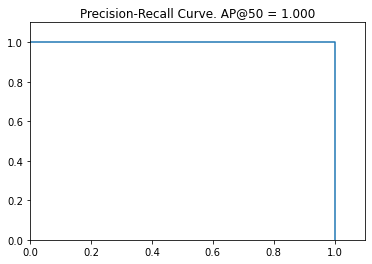

In [83]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

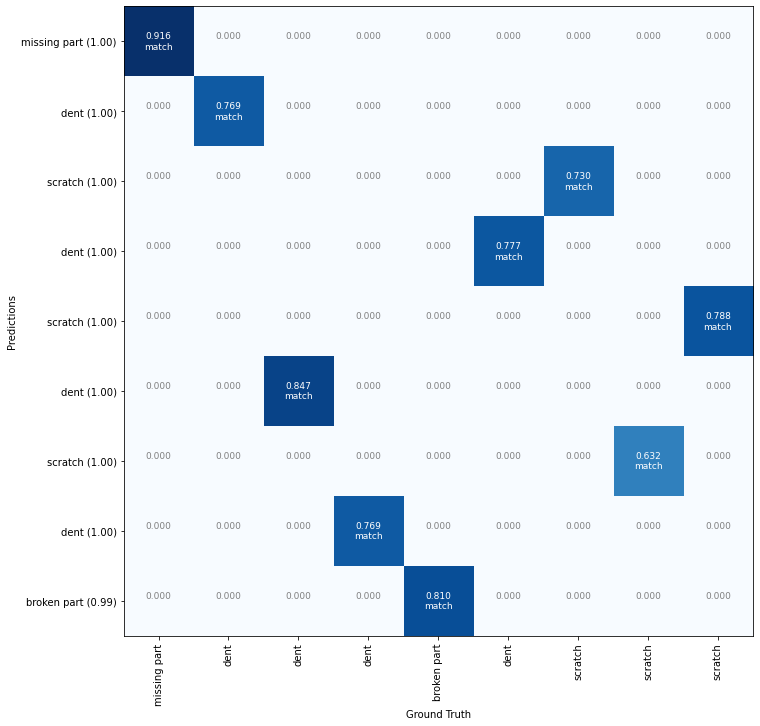

In [84]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

In [85]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.8953296698629856


In [88]:
!pip install scikit-learn

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from mrcnn.utils import compute_overlaps

gt_classes_all = []
pred_classes_all = []

IOU_THRESHOLD = 0.5

for image_id in dataset_val.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
        dataset_val, config, image_id, use_mini_mask=False)
    results = model.detect([image], verbose=0)
    r = results[0]

    pred_boxes = r['rois']
    pred_class_ids = r['class_ids']

    # Case 1: No predictions and no GT → skip
    if pred_boxes.shape[0] == 0 and gt_bbox.shape[0] == 0:
        continue

    # Case 2: Predictions exist, but no GT → all are false positives
    if gt_bbox.shape[0] == 0:
        for pred_class in pred_class_ids:
            gt_classes_all.append(0)  # background
            pred_classes_all.append(pred_class)
        continue

    # Case 3: GT exists, but no predictions → all are false negatives
    if pred_boxes.shape[0] == 0:
        for gt_class in gt_class_id:
            gt_classes_all.append(gt_class)
            pred_classes_all.append(0)  # background
        continue

    # Case 4: Both predictions and GT exist → do IoU matching
    overlaps = compute_overlaps(pred_boxes, gt_bbox)

    assigned_gt = set()
    for i, pred_class_id in enumerate(pred_class_ids):
        max_iou_idx = np.argmax(overlaps[i])
        max_iou = overlaps[i, max_iou_idx]

        if max_iou >= IOU_THRESHOLD and max_iou_idx not in assigned_gt:
            matched_gt_class_id = gt_class_id[max_iou_idx]
            gt_classes_all.append(matched_gt_class_id)
            pred_classes_all.append(pred_class_id)
            assigned_gt.add(max_iou_idx)
        else:
            # False positive
            gt_classes_all.append(0)  # background
            pred_classes_all.append(pred_class_id)

    # False negatives
    for j, gt_class in enumerate(gt_class_id):
        if j not in assigned_gt:
            gt_classes_all.append(gt_class)
            pred_classes_all.append(0)  # background

# Compute confusion matrix
cm = confusion_matrix(gt_classes_all, pred_classes_all, labels=list(range(len(dataset_val.class_names))))
print("Confusion Matrix:\n", cm)

# Print classification report
print("\nClassification Report:")
print(classification_report(
    gt_classes_all, pred_classes_all, target_names=dataset_val.class_names, zero_division=0))


Confusion Matrix:
 [[  0  23  18  23   1   4  22]
 [  8  65   0   0   0   0   0]
 [ 16   0  34   0   0   0   0]
 [  7   0   0 142   0   0   0]
 [  0   0   0   0   4   0   0]
 [  0   0   0   0   0  77   0]
 [ 25   0   0   0   0   0 132]]

Classification Report:
              precision    recall  f1-score   support

          BG       0.00      0.00      0.00        91
 broken part       0.74      0.89      0.81        73
       crack       0.65      0.68      0.67        50
        dent       0.86      0.95      0.90       149
 lamp broken       0.80      1.00      0.89         4
missing part       0.95      1.00      0.97        77
     scratch       0.86      0.84      0.85       157

    accuracy                           0.76       601
   macro avg       0.69      0.77      0.73       601
weighted avg       0.71      0.76      0.73       601



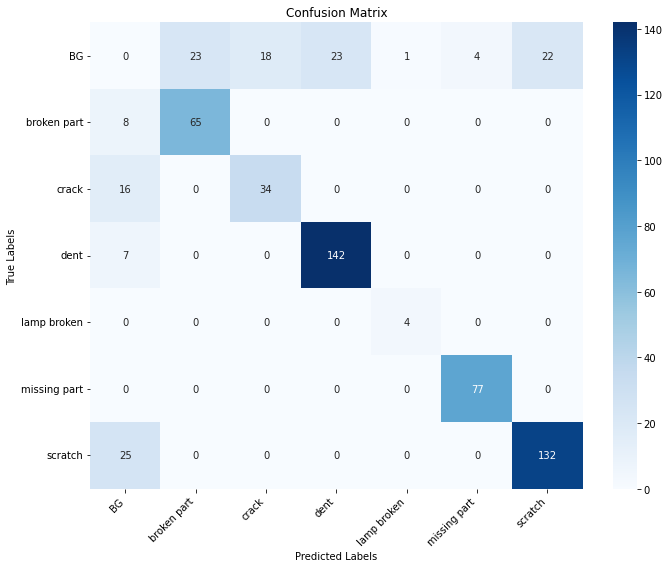

In [91]:
!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = list(range(len(dataset_val.class_names)))
class_names = dataset_val.class_names

# Compute confusion matrix
cm = confusion_matrix(gt_classes_all, pred_classes_all, labels=labels)

# Plot heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)

# Fix ticks and labels
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()



## Color Splash

This is for illustration. You can call `balloon.py` with the `splash` option to get better images without the black padding.

In [ ]:
splash = balloon.color_splash(image, r['masks'])
display_images([splash], cols=1)

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [ ]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


In [ ]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

In [ ]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 150
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

In [ ]:
# Show refined anchors after non-max suppression
limit = 150
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

In [ ]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 100
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [ ]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [ ]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

In [ ]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [ ]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

In [ ]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

#### Per-Class Non-Max Suppression

In [ ]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

In [ ]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

In [ ]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

In [ ]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

In [ ]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

In [ ]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [ ]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [ ]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)